# Exploratory Analysis
The insights from these analyses may be used in building the model and steps labeling algorithm.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib.lines import Line2D
import joblib

from src.data.labels_util import load_labels, LabelCol, get_labels_file, load_clean_labels, get_workouts
from src.data.imu_util import (
    get_sensor_file, ImuCol, load_imu_data, Sensor, fix_epoch, resample_uniformly, time_to_row_range, get_data_chunk,
    normalize_with_bounds, data_to_features, list_imu_abspaths, clean_imu_data
)
from src.data.util import find_nearest, find_nearest_index, shift, low_pass_filter, add_col
from src.data.workout import Activity, Workout
from src.data.data import DataState
from src.data.build_features import main as build_features
from src.data.features_util import list_test_files
from src.visualization.visualize import multiplot

# import data types
from pandas import DataFrame
from numpy import ndarray
from typing import List, Tuple, Optional

## Explore data smoothing
Explore the level of smoothing we should apply to the IMU data. The boot data, especially, is very noisy and requires heavy smoothing. We use low-pass filtering to smooth the data.

Looks like cut-offs of 2-3Hz for boot and 7-8Hz for pole would be worth trying. They reveal consistent patterns.

<IPython.core.display.Javascript object>


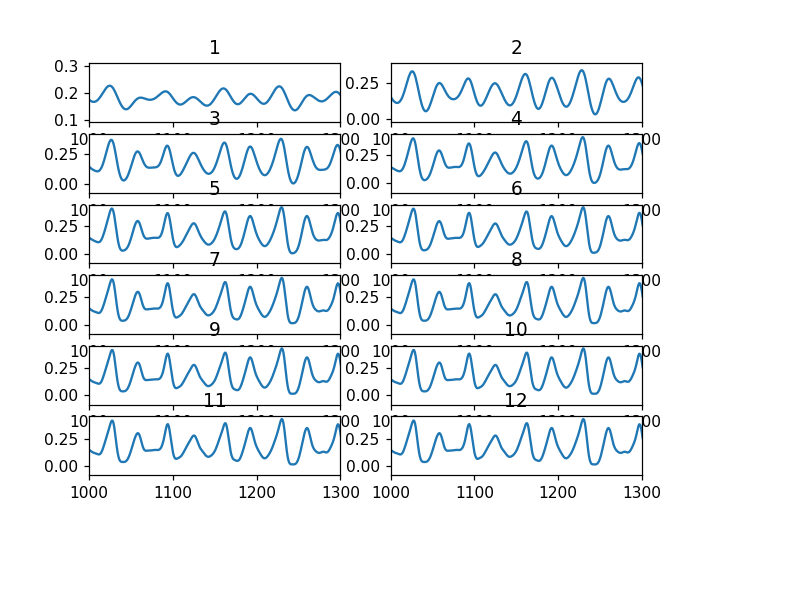

In [2]:
# WARNING: must be run after data cleaning and feature selection. Relies on data in test/

# Boot
features_file, labels_file = list_test_files(Activity.Boot)[1]
features: ndarray = np.load(features_file)
labels: ndarray = np.load(labels_file)
    
def plot_helper(idx, plot):
    cutoff = 1 + idx
    # apply filter
    plot.plot(low_pass_filter(features[:,0], cutoff=cutoff))
#     plot.plot(low_pass_filter(features[:,1], cutoff=cutoff))
#     plot.plot(low_pass_filter(features[:,2], cutoff=cutoff))
    plot.title.set_text(str(cutoff))
    
    plot.set_xlim([1000, 1300]) # Zoom (REMOVE to see the entire graph)
multiplot(12, plot_helper)

<IPython.core.display.Javascript object>


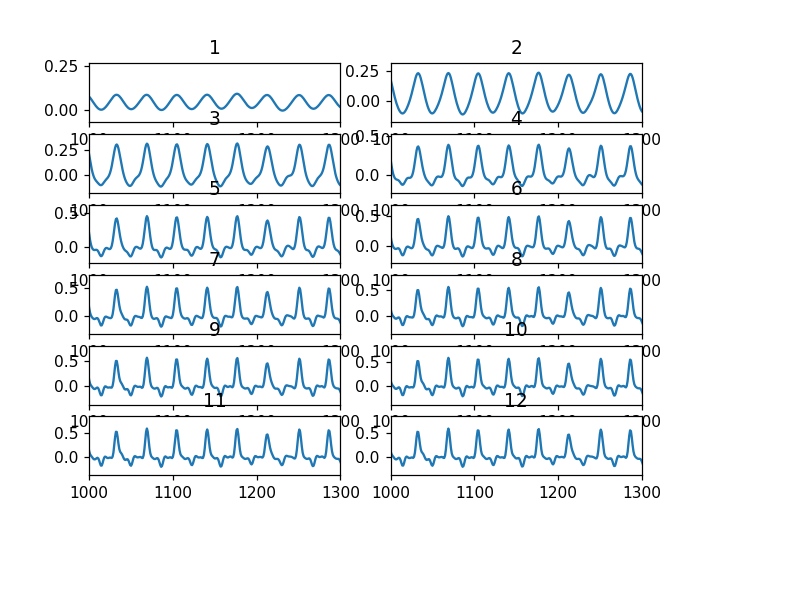

In [3]:
# Pole
features_file, labels_file = list_test_files(Activity.Pole)[1]
features: ndarray = np.load(features_file)
labels: ndarray = np.load(labels_file)
    
def plot_helper(idx, plot):
    cutoff = 1 + idx
    # apply filter
    plot.plot(low_pass_filter(features[:,0], cutoff=cutoff))
#     plot.plot(low_pass_filter(features[:,1], cutoff=cutoff))
#     plot.plot(low_pass_filter(features[:,2], cutoff=cutoff))
    plot.title.set_text(str(cutoff))
    
    plot.set_xlim([1000, 1300]) # Zoom (REMOVE to see the entire graph)
multiplot(12, plot_helper)

## Length of steps
Find the smallest duration of boot and pole steps

In [4]:
# WARNING: must be run after data cleaning. We labels to map to datapoints' **row numbers**

def plot_helper_by_activity(activity: Activity):
    labels: List[ndarray] = load_clean_labels(activity)
    step_sizes: List[int] = []
    for i in range(labels.shape[0]):
        start, end = labels[i, LabelCol.START], labels[i, LabelCol.END]
        if start is None or end is None:
            continue
        step_sizes.append(end - start + 1)

    def plot_helper(idx, plot):
        if idx == 0:
            plot.boxplot(step_sizes)
        if idx == 1:
            plot.hist(step_sizes, bins=30)
            
    return plot_helper

Boot:


<IPython.core.display.Javascript object>


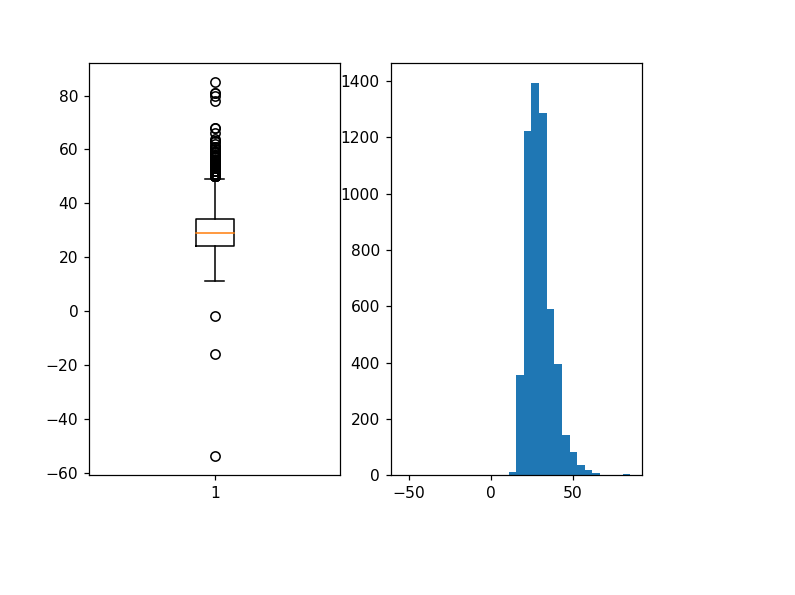

In [5]:
print('Boot:')
multiplot(2, plot_helper_by_activity(Activity.Boot))

Pole:


<IPython.core.display.Javascript object>


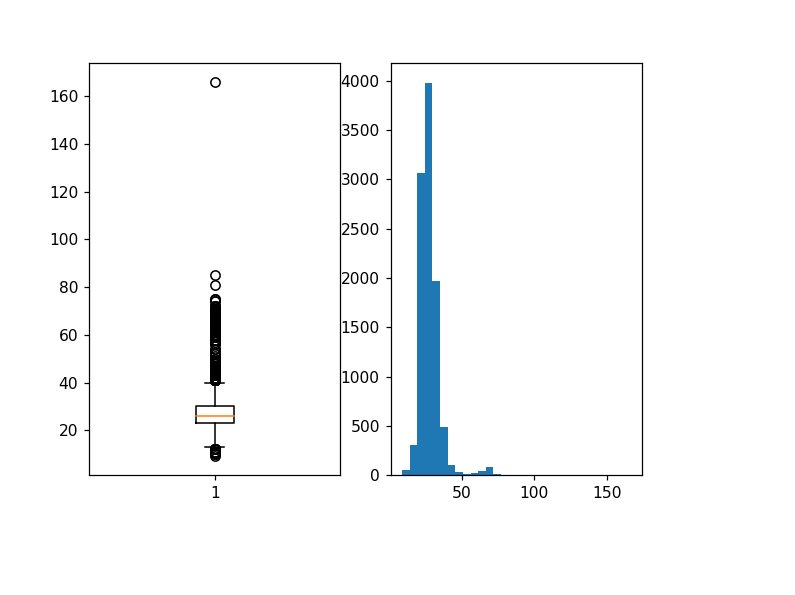

In [6]:
print('Pole:')
multiplot(2, plot_helper_by_activity(Activity.Pole))